# Desafio Cientista de Dados (Indicium)

A Indicium está desenvolvendo um modelo preditivo de preços para uma plataforma de aluguéis temporários em Nova York. Utilizando dados do maior concorrente, o modelo irá estimar os preços ideais para cada imóvel, maximizando a receita e a ocupação.

# 1 - EDA

## Importação das bibliotecas

In [35]:
# Importação das bibliotecas
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, ttest_ind
from collections import Counter
from google.colab import drive

# Importação de bibliotecas para ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.neural_network import MLPRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.keras.models import load_model

# Configuração do estilo estético das plotagens
sns.set_style()

# Configurações de visualização para DataFrames
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Configurações gerais de visualização
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = 'lightgray'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.dpi'] = 150

## Importação do Dataset

In [2]:
drive.mount('/content/drive')
df = pd.read_csv('/content/teste_indicium_precificacao.csv')

Mounted at /content/drive


## Exploração dos dados

In [3]:
print(df.head())

     id                                              nome  host_id    host_name bairro_group        bairro  latitude  longitude        room_type  price  minimo_noites  numero_de_reviews ultima_review  reviews_por_mes  calculado_host_listings_count  disponibilidade_365
0  2595                             Skylit Midtown Castle     2845     Jennifer    Manhattan       Midtown  40.75362  -73.98377  Entire home/apt    225              1                 45    2019-05-21             0.38                              2                  355
1  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632    Elisabeth    Manhattan        Harlem  40.80902  -73.94190     Private room    150              3                  0           NaN              NaN                              1                  365
2  3831                   Cozy Entire Floor of Brownstone     4869  LisaRoxanne     Brooklyn  Clinton Hill  40.68514  -73.95976  Entire home/apt     89              1                270    2019

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

In [5]:
print(df.describe())

                 id       host_id      latitude     longitude         price  minimo_noites  numero_de_reviews  reviews_por_mes  calculado_host_listings_count  disponibilidade_365
count  4.889400e+04  4.889400e+04  48894.000000  48894.000000  48894.000000   48894.000000       48894.000000     38842.000000                   48894.000000         48894.000000
mean   1.901753e+07  6.762139e+07     40.728951    -73.952169    152.720763       7.030085          23.274758         1.373251                       7.144005           112.776169
std    1.098288e+07  7.861118e+07      0.054529      0.046157    240.156625      20.510741          44.550991         1.680453                      32.952855           131.618692
min    2.595000e+03  2.438000e+03     40.499790    -74.244420      0.000000       1.000000           0.000000         0.010000                       1.000000             0.000000
25%    9.472371e+06  7.822737e+06     40.690100    -73.983070     69.000000       1.000000           1.00

  A análise estatística descritiva básica (média, mediana, desvio padrão, mínimos e máximos) é mais relevante para variáveis numéricas, pois fornece insights sobre dispersão, tendência central e distribuição dos dados.
  
  Na analise de preço (*price*), a média é de 152,72 dólares, mas a mediana é de 69 dólares, indicando que a distribuição dos preços está assimétrica, provavelmente com valores extremos (*outliers*), como o valor máximo de 10.000 dólares, e o preço mínimo de 0 dólares, assim é necessário a etapa de tratamento de valores inconsistentes.

## Tratamento de valores inconsistentes

In [6]:
print(df.isnull().sum())

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64


A análise dos dados revela que a maioria das colunas apresenta nenhum valor nulo, indicando um conjunto de dados relativamente limpo. No entanto, as colunas "nome", "host_name", "ultima_review" e "reviews_por_mes" apresentam um número considerável de valores ausentes.

In [7]:
print((df == 0).sum())

id                                   0
nome                                 0
host_id                              0
host_name                            0
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                               11
minimo_noites                        0
numero_de_reviews                10052
ultima_review                        0
reviews_por_mes                      0
calculado_host_listings_count        0
disponibilidade_365              17533
dtype: int64


Pode-se observar que a lógica demonstra que, em *numero_de_reviews* onde o número total de avaliações  é igual a zero, as variáveis *ultima_review* e *reviews_por_mes* são nulas. Isso reflete a ausência de avaliações históricas para esses anúncios. A relação entre essas variáveis é intrínseca, uma vez que a frequência média de avaliações mensais (*reviews_por_mes*) depende do número acumulado de avaliações, e a data da última avaliação (*ultima_review*) só é registrada para anúncios com pelo menos uma interação. Assim, a ausência de valores nessas colunas não deve ser interpretada como inconsistência dos dados, mas como uma característica dos registros que ainda não receberam avaliações.

In [8]:
numeric_cols = df.select_dtypes(include=['int64', 'float64'])
df_negativos = numeric_cols < 0
linhas_com_negativos = df[df_negativos.any(axis=1)]
print(df_negativos.sum())

id                                   0
host_id                              0
latitude                             0
longitude                        48894
price                                0
minimo_noites                        0
numero_de_reviews                    0
reviews_por_mes                      0
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64


A análise dos dados revela que a maioria das colunas apresenta nenhum valor negativo, mais um indicativo de um conjunto de dados relativamente limpo, uma vez que valores negativos para a maioria das colunas seriam ilógicos. No entanto, a coluna "longitude" apresenta valores negativos, o que é plausível, uma vez que a longitude pode assumir valores negativos no hemisfério oeste.

In [9]:
df = df[df['price'] >= 30]
df['reviews_por_mes'].fillna(0, inplace=True)
df['ultima_review'].fillna(0, inplace=True)
df['taxa_ocupacao_anual'] = (365 - df['disponibilidade_365']) / 365

<ipython-input-9-0e920bb9fae4>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['reviews_por_mes'].fillna(0, inplace=True)
<ipython-input-9-0e920bb9fae4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reviews_por_mes'].fillna(0, inplace=True)
<ipython-input-9-0e920bb9fae4>:3: FutureWarning: A value is trying to be set on a copy of a D

- Preços: Remover preços nulos e muito baixos garante que a análise seja feita com dados válidos e consistentes, uma vez que preços zerados não fazem sentido em um contexto comercial e valores muito baixos podem indicar erros na coleta de dados que dificultariam a análise. Em uma cidade como Nova York, mesmo os anúncios mais acessíveis tendem a ter preços acima de 30 dolares (estimativa), especialmente devido aos custos de operação e a alta demanda.

- Última review e Reviews por mês: Substituir NaN por 0 indica que não há reviews, algo que é plausível para novos anuncios.


- Disponibilidade anual: A criação da coluna "taxa_ocupacao_anual" a partir dos dados permite uma interpretação mais intuitiva da disponibilidade dos imóveis, uma vez que quanto maior a taxa de ocupação, menos dias disponíveis no ano.

## Análises estatisticas

### Análise de correlação

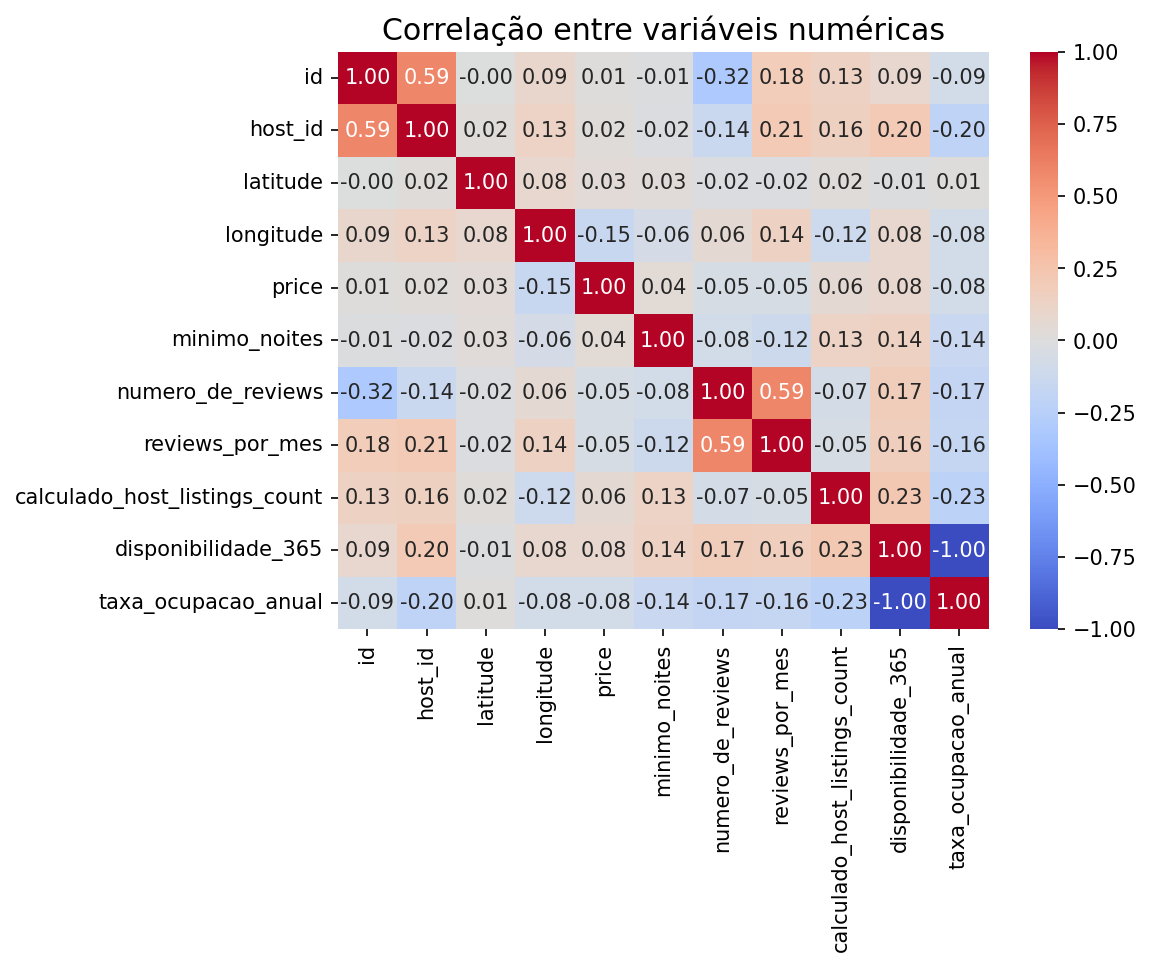

In [10]:
numeric_cols = df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(7, 5))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlação entre variáveis numéricas")
plt.show()

- numero_de_reviews e reviews_por_mes (0.59): Há uma correlação positiva significativa, o que faz sentido, já que propriedades com mais avaliações totais provavelmente têm mais avaliações mensais.

- disponibilidade_365 e taxa_ocupacao_anual (-1.00): Essa relação é perfeitamente negativa, indicando que as duas variáveis são inversamente relacionadas, o que é claro já que a taxa de ocupação anual foi uma coluna criada a partir da disponibilidade_365 para facilitar a compreensão.

- calculado_host_listings_count e disponibilidade_365 (0.23): Há uma correlação positiva fraca, o que sugere que anfitriões com mais propriedades podem ter listagens disponíveis por mais dias.

- Variáveis como latitude e longitude têm pouca ou nenhuma relação linear com outras variáveis, o que é esperado, pois são mais geográficas.

### Segmentação de Dados

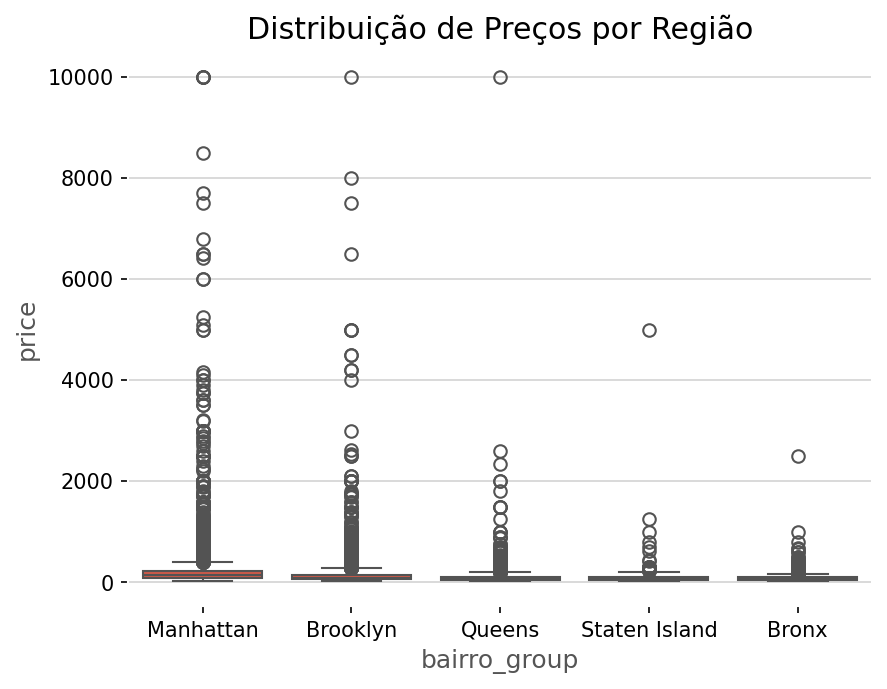

In [11]:
sns.boxplot(data=df, x="bairro_group", y="price")
plt.title("Distribuição de Preços por Região")
plt.show()

A análise da distribuição de preços por região revela diferenças significativas entre os bairros. Manhattan destaca-se como a região com os preços mais altos, apresentando grande variação e muitos outliers que chegam a valores próximos de 10.000 dólares, refletindo sua alta demanda e status premium. Brooklyn também possui preços elevados, mas geralmente abaixo dos de Manhattan, enquanto Queens apresenta valores moderados com menor dispersão. Staten Island e Bronx, por outro lado, são as regiões mais acessíveis, com preços mais baixos e menos variabilidade. A mediana dos preços confirma essas tendências, sendo mais alta em Manhattan e mais baixa em Bronx e Staten Island. Essas diferenças refletem as características socioeconômicas e o apelo de cada região.

In [12]:
def remover_outliers_por_regiao(df, coluna_regiao, coluna_preco):
    df_sem_outliers = pd.DataFrame()
    for regiao in df[coluna_regiao].unique():
        dados_regiao = df[df[coluna_regiao] == regiao]

        Q1 = dados_regiao[coluna_preco].quantile(0.25)
        Q3 = dados_regiao[coluna_preco].quantile(0.75)
        IQR = Q3 - Q1

        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        dados_filtrados = dados_regiao[(dados_regiao[coluna_preco] >= limite_inferior) & (dados_regiao[coluna_preco] <= limite_superior)]

        df_sem_outliers = pd.concat([df_sem_outliers, dados_filtrados])

    return df_sem_outliers

df_sem_outliers = remover_outliers_por_regiao(df, 'bairro_group', 'price')

print(f'dados antes: {len(df)}')
print(f'dados depois: {len(df_sem_outliers)}')


dados antes: 48490
dados depois: 45796


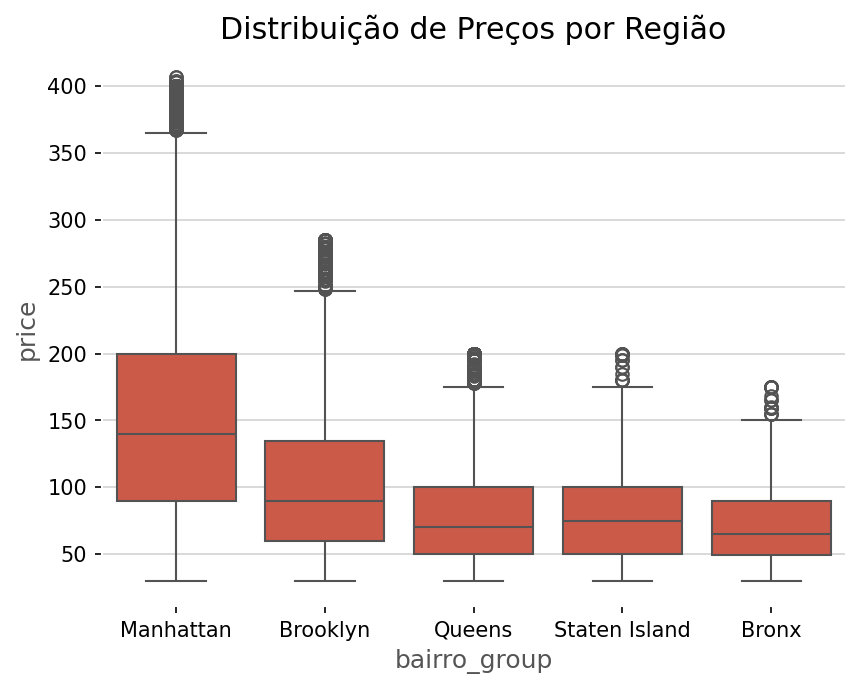

In [17]:
df=df_sem_outliers
sns.boxplot(data=df, x='bairro_group', y='price')
plt.title('Distribuição de Preços por Região')
plt.show()

Após remover os outliers por região e plotar um novo boxplot, a distribuição de preços tornou-se mais representativa e alinhada às características de cada local. Em Manhattan, os preços continuam elevados, mas com menor dispersão. Regiões como Bronx, Staten Island e Queens mantiveram seus padrões de preços baixos, enquanto Brooklyn mostra valores moderados com menor variabilidade.

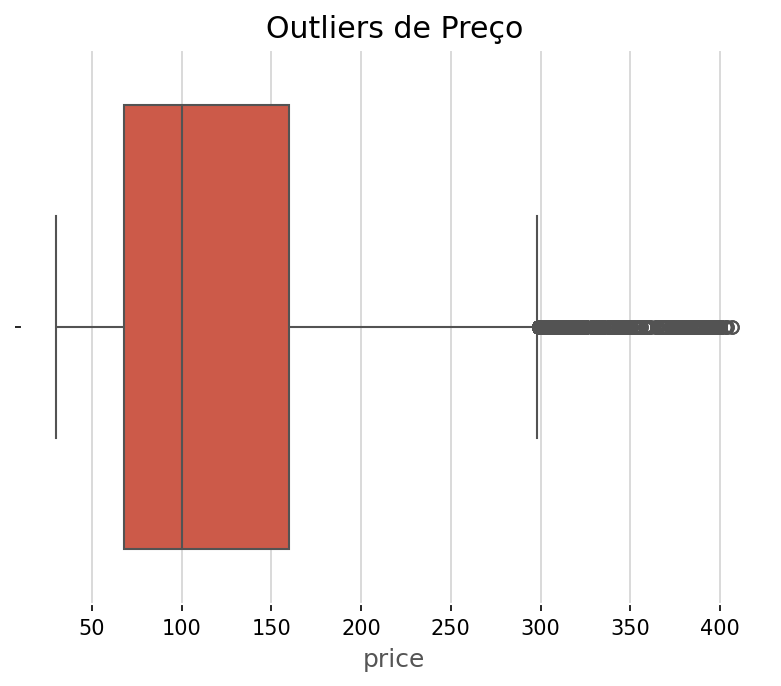

In [18]:
sns.boxplot(x=df['price'])
plt.title("Outliers de Preço")
plt.show()

Após análise detalhada do boxplot e considerando o contexto do mercado imobiliário, optou-se por manter os outliers identificados. A presença de imóveis com preços significativamente mais altos pode ser justificada por diversas razões, como localização em regiões nobres (como Manhattan) ou características de luxo descritas no campo 'nome'. Esses outliers, ao contrário dos anteriormente identificados, apresentam valores mais coerentes com o mercado imobiliário e podem representar segmentos importantes do mercado, como o de imóveis de luxo.

In [19]:
print(df.describe())

                 id       host_id      latitude     longitude         price  minimo_noites  numero_de_reviews  reviews_por_mes  calculado_host_listings_count  disponibilidade_365  taxa_ocupacao_anual
count  4.579600e+04  4.579600e+04  45796.000000  45796.000000  45796.000000   45796.000000       45796.000000     45796.000000                   45796.000000         45796.000000         45796.000000
mean   1.888654e+07  6.625484e+07     40.729260    -73.951940    123.496332       6.995393          23.816796         1.102696                       7.019674           109.356560             0.700393
std    1.093591e+07  7.762310e+07      0.054686      0.045601     73.599610      20.349143          45.215951         1.610930                      32.392716           130.267564             0.356897
min    2.595000e+03  2.438000e+03     40.499790    -74.244420     30.000000       1.000000           0.000000         0.000000                       1.000000             0.000000             0.000000


Após o tratamento dos dados, observa-se uma redução no número de registros de 48.894 para 45.796, reflexo da remoção de valores inconsistentes e outliers, especialmente na variável price. A média do preço por noite caiu de 152,72 dólares para 123,50 dólares, indicando que os valores extremos anteriormente presentes (como o máximo de 10.000 dólares e mínimo de 0) foram eliminados, reduzindo a dispersão, agora com um desvio padrão de 73,60 dólares (antes 240,16). A mediana também se ajustou, passando de 69 dólares para 100 dólares, aproximando-se da realidade central do mercado. Além disso, o valor mínimo do preço subiu de 0 dólares para 30 dólares, o que elimina registros inválidos ou não representativos. Por fim, a inclusão da variável taxa_ocupacao_anual fornece uma métrica adicional para analisar a disponibilidade dos imóveis, com valores variando entre 0 e 1, permitindo uma interpretação mais clara da ocupação em diferentes cenários.

## Testes de Hipóteses

### Relação entre taxa de ocupação anual e preço

A lógica é baseada na relação entre demanda e precificação. Se um imóvel tem uma taxa de ocupação anual alta, isso pode indicar que ele é mais desejado pelos hóspedes, o que permitiria ao anfitrião cobrar preços mais elevados. Por outro lado, pode ser que imóveis mais baratos tenham uma alta ocupação simplesmente porque são acessíveis. Nesse teste será possível esclarecer se há uma associação real entre essas variáveis, e qual será a correta interpretação.

- Hipótese Nula (H₀): A taxa de ocupação anual não está associada ao preço do imóvel.

- Hipótese Alternativa (H₁): Existe uma correlação significativa entre taxa de ocupação anual e preço.

In [20]:
correlacao, p_valor = spearmanr(df['taxa_ocupacao_anual'], df['price'])

print(f'Coeficiente de Spearman: {correlacao:.4f}')
print(f'Valor-p: {p_valor:.4f}')

Coeficiente de Spearman: -0.0520
Valor-p: 0.0000


O coeficiente de Spearman foi -0.0520, indicando uma correlação negativa fraca entre a taxa de ocupação anual e o preço do imóvel. Ou seja, à medida que a taxa de ocupação aumenta, o preço tende a diminuir levemente, embora a relação seja muito fraca. O valor-p 0.0000 é altamente significativo (p < 0.05), o que nos leva a rejeitar a hipótese nula (H₀). Isso significa que existe uma associação estatisticamente significativa entre taxa de ocupação e preço, mas essa relação é fraca e negativa, sugerindo que imóveis mais baratos podem ter maior ocupação, devido aos preços mais acessíveis.

### Relação entre ausência de avaliações e preços médios



Nesse tipo de mercado, anfitriões e imóveis sem avaliações podem ter dificuldade em atrair hóspedes, pois novos usuários e anúncios podem ser vistos com desconfiança. Para compensar essa falta de reputação, esses anfitriões podem reduzir os preços para torná-los mais atraentes.

- Hipótese Nula (H₀): Não há diferença significativa entre os preços médios de imóveis com e sem avaliações.

- Hipótese Alternativa (H₁): Imóveis sem avaliações possuem preços médios diferentes dos que possuem avaliações.

In [21]:
sem_reviews = df[df['numero_de_reviews'] == 0]['price']
com_reviews = df[df['numero_de_reviews'] > 0]['price']

estatistica, p_valor = ttest_ind(sem_reviews, com_reviews, equal_var=False)

print(f'Estatística t: {estatistica:.4f}')
print(f'Valor-p: {p_valor:.4f}')

media_sem_avaliacoes = df[df['numero_de_reviews'] == 0]['price'].mean()
media_com_avaliacoes = df[df['numero_de_reviews'] > 0]['price'].mean()

print(f'Média sem avaliações: {media_sem_avaliacoes:.2f}')
print(f'Média com avaliações: {media_com_avaliacoes:.2f}')


Estatística t: 14.7001
Valor-p: 0.0000
Média sem avaliações: 134.77
Média com avaliações: 120.70


A estatística t de 14.7001 e o valor-p 0.0000 indicam que há uma diferença estatisticamente significativa (p < 0.05) entre os preços médios de imóveis com e sem avaliações. No entanto, ao analisar as médias, vemos que imóveis sem avaliações têm um preço médio de 134.77, enquanto os imóveis com avaliações têm um preço médio de 120.70. Isso contradiz a hipótese inicial de que imóveis sem avaliações teriam preços mais baixos. Assim, embora rejeitemos a hipótese nula (H₀, que afirmava não haver diferença nos preços), a diferença observada sugere que, na verdade, imóveis sem avaliações tendem a ter preços mais altos, o que pode indicar que novos anunciantes não necessariamente reduzem os preços para atrair hóspedes.

Novos anfitriões podem começar com preços elevados para testar o mercado e verificar se conseguem reservas sem precisar reduzi-los inicialmente. Isso pode ocorrer também porque anfitriões novos, ainda sem experiência na plataforma, não conhecem bem sua dinâmica e acabam definindo preços mais altos na expectativa de atrair hóspedes, sem perceber que imóveis mais baratos com avaliações podem ser mais competitivos.

### Impacto do número mínimo de noites nos preços

Imóveis que exigem uma estadia mínima mais longa podem ter preços médios mais baixos para atrair hóspedes dispostos a compromissos maiores. Isso ocorre porque estadias curtas costumam gerar mais trabalho para o anfitrião (limpeza, manutenção), enquanto reservas longas oferecem maior previsibilidade e estabilidade de renda.

- Hipótese Nula (H₀): Imóveis com um número mínimo de noites maior que 5 não apresentam diferença significativa no preço médio em relação aos imóveis com um número mínimo menor ou igual a 5.

- Hipótese Alternativa (H₁): Imóveis com um número mínimo de noites maior que 5 possuem preços médios significativamente diferentes.

In [22]:
noites_curto_prazo = df[df['minimo_noites'] <= 5]['price']
noites_longo_prazo = df[df['minimo_noites'] > 5]['price']

estatistica, p_valor = ttest_ind(noites_curto_prazo, noites_longo_prazo, equal_var=False)

print(f'Estatística t: {estatistica:.4f}')
print(f'Valor-p: {p_valor:.4f}')

media_curto_prazo = noites_curto_prazo.mean()
media_longo_prazo = noites_longo_prazo.mean()

print(f'Média curto prazo: {media_curto_prazo:.2f}')
print(f'Média longo prazo: {media_longo_prazo:.2f}')


Estatística t: -6.3405
Valor-p: 0.0000
Média curto prazo: 122.33
Média longo prazo: 127.93


Com base nos resultados do teste t, a estatística t obtida foi -6.3405 e o valor-p foi 0.0000. O valor-p muito baixo indica que a diferença observada entre os preços curto prazo e longo prazo é significativa. Além disso, as médias dos preços curto prazo (122,33 dólares) e longo prazo (127,93 dólares) são diferentes, com uma diferença de apenas 5,60 dólares. Dado que o valor-p é inferior ao nível de significância usual de 0,05, rejeitamos a hipótese nula de que não há diferença significativa entre os preços médios dos dois grupos.

Embora a diferença tenha sido estatisticamente significativa, o tamanho da diferença nas médias pode ser considerada pequena em termos práticos. Isso sugere que, embora a distribuição dos preços dos dois grupos seja diferente, outros fatores além da duração da estadia podem influenciar o preço dos imóveis de maneira mais significativa. Portanto, apesar da rejeição da hipótese nula, é importante considerar que a significância estatística não implica necessariamente uma diferença substantiva no contexto real.

# 2 - Perguntas específicas

## Onde seria mais indicada a compra?

Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?


In [23]:
preco_bairro_group_media = df.groupby('bairro_group')['price'].mean().sort_values(ascending=False)
print('Média de Preço por Bairro Group (Ordenado):')
print(preco_bairro_group_media)

Média de Preço por Bairro Group (Ordenado):
bairro_group
Manhattan        155.846248
Brooklyn         103.388474
Queens            82.684911
Staten Island     81.849558
Bronx             73.479959
Name: price, dtype: float64


In [24]:
avaliacoes_bairro_group_media = df.groupby('bairro_group')['numero_de_reviews'].mean().sort_values(ascending=False)
print('Média de Avaliações por Bairro Group (Ordenado):')
print(avaliacoes_bairro_group_media)

Média de Avaliações por Bairro Group (Ordenado):
bairro_group
Staten Island    32.616519
Queens           28.474534
Bronx            27.446043
Brooklyn         24.613431
Manhattan        21.549766
Name: numero_de_reviews, dtype: float64


In [25]:
taxa_ocupacao_bairro_group_media = df.groupby('bairro_group')['taxa_ocupacao_anual'].mean().sort_values(ascending=False)
print('Média de Taxa de Ocupação Anual por Bairro Group (Ordenado):')
print(taxa_ocupacao_bairro_group_media)

Média de Taxa de Ocupação Anual por Bairro Group (Ordenado):
bairro_group
Brooklyn         0.732137
Manhattan        0.704623
Queens           0.614815
Bronx            0.547548
Staten Island    0.444361
Name: taxa_ocupacao_anual, dtype: float64


Analisando os resultados de preço médio, número de avaliações e taxa de ocupação anual por bairro_group, podemos identificar as melhores regiões para investir. Manhattan apresenta o preço médio mais alto, o que pode gerar um maior retorno financeiro, mas a taxa de ocupação e o número de avaliações são mais baixos, indicando uma demanda um pouco menor. Staten Island e Bronx têm preços mais baixos, o que torna o investimento mais acessível, e apresentam uma maior taxa de ocupação e mais avaliações, sugerindo alta demanda e uma boa rotatividade de inquilinos, embora o retorno por unidade alugada seja menor. Brooklyn oferece uma boa combinação de preço razoável e alta taxa de ocupação, tornando-se uma opção interessante para quem busca um fluxo de caixa constante.

Se o investidor está em busca de um fluxo de caixa constante e boa demanda, Brooklyn pode ser a escolha ideal. Para um investimento com baixo custo inicial e alta rotatividade, Staten Island e Bronx são boas opções. Se o objetivo for maior retorno a longo prazo e valorização do imóvel, Manhattan pode ser vantajosa, apesar do preço elevado e maior risco. A escolha final vai depender do perfil do investidor e dos seus objetivos financeiros, equilibrando preço, demanda e risco.

##O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?


Sim, o número mínimo de noites e a disponibilidade ao longo do ano interferem no preço, mas de maneiras específicas.

- Número mínimo de noites: O teste de hipótese realizado anteriormente na seção "Teste de hipóteses", subseção "Impacto do número mínimo de noites nos preços" pode avaliar a influência do número mínimo de noites no preço e revelou que imóveis que exigem estadias mais longas (mais de 5 noites) apresentam preços médios ligeiramente mais altos do que os imóveis que permitem estadias curtas. O valor-p obtido foi extremamente baixo (p = 0.0000), o que indica que a diferença nos preços é estatisticamente significativa. No entanto, a diferença nas médias de preços (127,93 dólares para estadias longas e 122,33 dólares para estadias curtas) é pequena, sugerindo que, apesar da significância estatística, a diferença prática no preço não é grande. Isso reforça a ideia de que, embora o número mínimo de noites tenha um efeito sobre o preço, outros fatores também podem influenciar o valor dos imóveis.

- Taxa de ocupação anual: A correlação entre a taxa de ocupação anual e o preço do imóvel também foi analisada anteriormente na seção "Teste de hipóteses", subseção "Relação entre taxa de ocupação anual e preço". O coeficiente de Spearman foi -0.0520, indicando uma correlação fraca e negativa entre essas variáveis. Embora a relação seja estatisticamente significativa (valor-p = 0.0000), a correlação é tão fraca que sugere que imóveis com maior taxa de ocupação tendem a ter preços ligeiramente mais baixos. Isso pode ocorrer porque imóveis mais baratos atraem mais inquilinos, o que aumenta a ocupação, mas limita o preço cobrado. Vale ressaltar que a taxa de ocupação anual é inversamente correlacionada com a disponibilidade anual dos imóveis. Quanto menor a disponibilidade do imóvel ao longo do ano, maior a taxa de ocupação, e vice-versa. Ou seja, imóveis com maior disponibilidade durante o ano tendem a ter uma menor taxa de ocupação, enquanto aqueles com menor disponibilidade acabam sendo mais ocupados. Isso implica que essas duas variáveis têm uma relação direta e perfeitamente inversa sendo válida para analisar a disponibilidade anual.

##Existe algum padrão no texto do nome do local para lugares de mais alto valor?

In [26]:
preco_25_porcento = df['price'].quantile(0.75)
imoveis_alto_valor = df[df['price'] > preco_25_porcento]

imoveis_alto_valor = imoveis_alto_valor[imoveis_alto_valor['nome'].notna()]
imoveis_alto_valor = imoveis_alto_valor[imoveis_alto_valor['nome'].apply(lambda x: isinstance(x, str))]

nomes_divididos = imoveis_alto_valor['nome'].str.split()

todas_as_palavras = [palavra.lower() for nome in nomes_divididos for palavra in nome]

stop_words = {'in', 'of', 'the', 'a', 'an', 'and', 'on', 'at', 'to', 'for', 'with', 'by', '1', '2', '|', '&', '1br', 'bedroom'}

todas_as_palavras_filtradas = [palavra for palavra in todas_as_palavras if palavra not in stop_words]

frequencia_palavras = Counter(todas_as_palavras_filtradas)

palavras_comum = frequencia_palavras.most_common(10)

for palavra, frequencia in palavras_comum:
    print(f'{palavra}: {frequencia}')

apartment: 1724
apt: 1132
studio: 1074
east: 1028
village: 972
spacious: 786
luxury: 750
west: 730
park: 729
manhattan: 600


Com base na análise realizada utilizando os 25% mais caros como critério para identificar lugares de alto valor, foram identificados padrões claros nos textos dos nomes desses locais. Termos como "apartment" (1724 ocorrências), "apt" (1132) e "studio" (1074) destacam a predominância de imóveis residenciais com estrutura de cômodos completa, enquanto palavras como "luxury" (750) e "spacious" (786) indicam características associadas ao conforto, sofisticação e exclusividade.

Nas referências geográficas, termos como "east" (1028), "west" (730), "village" (972) e "manhattan" (600) sugerem uma forte valorização de regiões específicas de Nova York. Em particular, a presença de "manhattan" como um dos termos mais frequentes evidencia a concentração de imóveis de maior valor nessa área altamente desejada. Além disso, a menção recorrente de "park" (729) está provavelmente relacionada à proximidade do Central Park, um dos marcos mais icônicos da cidade e frequentemente associado a imóveis premium.

Essas repetições mostram que há, sim, um padrão no texto do nome do local para lugares de mais alto valor.

# 3 - Modelos de previsão

### Random Forest Regressor

In [43]:
X = df.drop(columns=['id', 'nome', 'host_id', 'host_name', 'price', 'ultima_review'])
X = pd.get_dummies(X, drop_first=True)
y = df['price']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=150, random_state=42)

rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=150, random_state=42)

In [44]:
with open("random_forest.pkl", "wb") as f:
    pickle.dump(rf, f)

In [45]:
with open("random_forest.pkl", "rb") as f:
    loaded_rf_model = pickle.load(f)

y_pred = loaded_rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2= r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f'RMSE: {rmse}')
print(f'R²: {r2}')
print(f'MAPE: {mape}%')

RMSE: 47.49621415065279
R²: 0.577207149093655
MAPE: 30.254922794675483%


O modelo utilizado é o Random Forest Regressor, uma técnica de aprendizado de máquina baseada na construção de várias árvores de decisão. Esse modelo foi escolhido para teste por sua robustez e capacidade de lidar bem com dados complexos e não-lineares, como no caso da previsão de preços de imóveis. Este é um problema de regressão, pois estamos tentando prever um valor contínuo, que é o preço dos imóveis. A regressão é adequada para esse tipo de problema, em que o objetivo é estimar um número real, e não classificar em categorias discretas, como no caso da classificação.

O modelo foi treinado utilizando variáveis numéricas e categóricas. A variável preço do imóvel foi definida como o alvo (y), enquanto outras variáveis, como características do imóvel, localização e número de avaliações, foram usadas como variáveis preditoras (X). Além disso, foi aplicada a normalização das variáveis para padronizar os dados e melhorar o desempenho do modelo, especialmente em casos de variáveis com diferentes escalas.

As métricas fornecem uma boa visão sobre o desempenho do modelo. O RMSE (Root Mean Squared Error) indica a magnitude dos erros em unidades monetárias, sendo que um valor menor é desejado. O R² mostra a capacidade do modelo de explicar a variação dos dados, quanto mais próximo de 1, melhor o modelo. No caso, um R² de 0.577 sugere que o modelo tem um desempenho razoável, explicando cerca de 57.7% da variabilidade dos preços. O MAPE (Mean Absolute Percentage Error) indica a precisão do modelo em termos percentuais. Com um valor de aproximadamente 30.25%, o modelo está errando em média 30.25% do preço real, um erro considerável, mas ainda assim razoável para esse tipo de problema.

### RNA

In [46]:
X = df.drop(columns=['id', 'nome', 'host_id', 'host_name', 'price', 'ultima_review'])
X = pd.get_dummies(X, drop_first=True)
y = df['price']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = Sequential()

model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1))

model.compile(optimizer=Adam(), loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

model.save("neural.h5")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1145/1145 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 8226.5293 - val_loss: 2513.8662
Epoch 2/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 2554.7585 - val_loss: 2474.6260
Epoch 3/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 2483.9578 - val_loss: 2500.3572
Epoch 4/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 2443.2031 - val_loss: 2444.9556
Epoch 5/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 2425.1956 - val_loss: 2441.0754
Epoch 6/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2413.4766 - val_loss: 2459.8635
Epoch 7/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 2384.4375 - val_loss: 2439.2148
Epoch 8/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 2423.8787 - val_loss: 2444.0698
Epoch 9/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 2350.6829 - val_loss: 2448.6292
Epoch 10/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2423.5486 - val_loss: 2455.8779
Epoch 11/100
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - los

In [47]:
loaded_model = load_model("neural.h5")

y_pred = loaded_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f'RMSE: {rmse}')
print(f'R²: {r2}')
print(f'MAPE: {mape}%')

287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
RMSE: 55.67877053492875
R²: 0.41898298263549805
MAPE: 32.960546016693115%


O modelo usado é uma rede neural artificial (RNA) para regressão, ou seja, um modelo de aprendizado de máquina que busca aprender uma função para prever uma variável contínua com base em variáveis independentes. O uso de uma RNA é adequado para este tipo de problema devido à sua flexibilidade e capacidade de aprender interações complexas entre as variáveis.

As variáveis do modelo foram cuidadosamente escolhidas e transformadas para garantir que o modelo funcionasse adequadamente. Primeiramente, variáveis como id, nome, host_id, host_name e ultima_review foram removidas, já que essas informações não são úteis para a previsão do preço do imóvel. Além disso, variáveis categóricas, como room_type e bairro_group, foram convertidas em variáveis binárias por meio do processo de one-hot encoding, que cria novas colunas para cada categoria, permitindo que a rede neural entenda essas variáveis corretamente.

A normalização das variáveis independentes foi realizada utilizando o StandardScaler, um passo importante em redes neurais, pois elas tendem a funcionar melhor quando as variáveis de entrada estão na mesma escala. Isso ajuda a evitar que uma variável com uma escala muito maior domine a aprendizagem, o que poderia prejudicar a precisão do modelo.

As métricas do modelo indicam um desempenho moderado. O RMSE de 55,67 revela que, em média, o erro quadrático entre os valores previstos e reais do preço dos imóveis é 55,67 unidades, sugerindo que o modelo ainda apresenta erros consideráveis. O R² de 0,41 indica que apenas 41% da variação do preço dos imóveis é explicada pelo modelo, o que demonstra um poder preditivo limitado. Já o MAPE de 32,96% aponta que o modelo está errando, em média, cerca de 32,96% na previsão do preço, o que pode ser considerado razoável, mas ainda longe de ser ideal, especialmente para problemas de precificação sensíveis.

### Support Vector Regression (SVR)

In [48]:
X = df.drop(columns=['id', 'nome', 'host_id', 'host_name', 'price', 'ultima_review'])
X = pd.get_dummies(X, drop_first=True)
y = df['price']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)

SVR()

In [49]:
with open("svr.pkl", "wb") as f:
    pickle.dump(svr, f)

In [50]:
with open("svr.pkl", "rb") as f:
    loaded_svr = pickle.load(f)

y_pred_loaded = loaded_svr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f'RMSE: {rmse}')
print(f'R²: {r2}')
print(f'MAPE: {mape}%')

RMSE: 55.67877053492875
R²: 0.41898298263549805
MAPE: 32.960546016693115%


O SVR é um modelo de aprendizado supervisionado que, ao invés de simplesmente ajustar uma linha reta como a regressão linear, busca um hiperplano de alta dimensão para realizar a previsão, ajustando-se a uma margem de erro controlada. Isso permite que o SVR capture relações mais complexas nos dados. A tarefa é prever valores numéricos, que são os preços dos imóveis.

As métricas fornecem uma visão sobre a performance do modelo. O RMSE de 55.67 indica que a média dos erros quadráticos entre as previsões e os valores reais é de aproximadamente 56 unidades monetárias, sugerindo que há margem para melhorias. O R² de 0.41 indica que o modelo consegue explicar cerca de 41% da variação dos preços, o que é relativamente baixo e sugere que o modelo não está capturando todas as variáveis relevantes ou há complexidade nos dados não capturada pelo modelo. Por fim, o MAPE de 32,96% indica que, em média, as previsões do modelo estão a cerca de 33% do valor real, o que é um valor considerável.

###Ensemble Learning

In [51]:
X = df.drop(columns=['id', 'nome', 'host_id', 'host_name', 'price', 'ultima_review'])
X = pd.get_dummies(X, drop_first=True)
y = df['price']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=150, random_state=42)
svr = SVR(kernel='rbf')
rna = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=100, random_state=42)

ensemble_model = VotingRegressor(estimators=[('rf', rf), ('svr', svr), ('rna', rna)])

ensemble_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(n_estimators=150,
                                                   random_state=42)),
                            ('svr', SVR()),
                            ('rna',
                             MLPRegressor(hidden_layer_sizes=(64, 32),
                                          max_iter=100, random_state=42))])

In [52]:
with open("ensemble.pkl", "wb") as f:
    pickle.dump(ensemble_model, f)

In [53]:
with open("ensemble.pkl", "rb") as f:
    loaded_ensemble_model = pickle.load(f)

y_pred = loaded_ensemble_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2= r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f'RMSE: {rmse}')
print(f'R²: {r2}')
print(f'MAPE: {mape}%')

RMSE: 47.818563811883806
R²: 0.571448811725535
MAPE: 29.68193536004591%


O modelo de ensemble é composto por três algoritmos: Random Forest Regressor, SVR e RNA. Para isso, ele realiza um pré-processamento nos dados, removendo colunas irrelevantes, além de transformar variáveis categóricas em numéricas. Em seguida, os dados são normalizados e depois, o conjunto de dados é dividido em treino e teste. O modelo combina os três algoritmos mencionados.

O RMSE obtido foi 47.82, indicando que o erro médio das previsões é de aproximadamente 47.82 unidades monetárias. O R² foi 0.57, mostrando que o modelo consegue explicar 57% da variabilidade dos preços. Já o MAPE foi 29.68%, o que significa que, em média, os erros de previsão representam 29.68% do preço real do imóvel.

### Qual modelo foi escolhido?

Com base nos resultados apresentados, o modelo que melhor se aproxima dos dados é o Random Forest. Ele apresentou um RMSE de 47.50, o maior R² (0.577) e um MAPE de 30.25%, destacando-se como o modelo mais preciso para prever os valores de preço. O Random Forest é robusto contra overfitting devido à sua abordagem de agregação de árvores, além de capturar bem relações não lineares entre as variáveis. No entanto, ele pode ser menos interpretável em comparação com modelos lineares.

A Rede Neural Artificial (RNA) apresentou um RMSE de 54.01, R² de 0.453 e MAPE de 31.23%. Esses resultados mostram que ela teve mais dificuldade em ajustar os dados do que os outros modelos.

O SVR, por sua vez, apresentou um RMSE de 54.21, R² de 0.449 e MAPE de 31.16%. O desempenho do SVR foi muito próximo ao da RNA, mas ligeiramente inferior em termos de RMSE e R².

O Ensemble Learning combinou os três modelos e apresentou um RMSE de 47.82, R² de 0.571 e MAPE de 29.68%. Embora tenha desempenho muito próximo ao Random Forest, com um RMSE ligeiramente maior e R² um pouco menor, o Ensemble obteve o menor MAPE, o que indica que foi o mais eficiente em termos de erro percentual relativo. A principal vantagem do Ensemble é combinar diferentes modelos, reduzindo a probabilidade de overfitting e aproveitando os pontos fortes de cada um. No entanto, ele herda algumas limitações dos modelos individuais e pode ser mais complexo de interpretar.

A medida de performance escolhida foi o RMSE. Essa métrica foi utilizada porque penaliza fortemente erros maiores, sendo ideal para problemas onde grandes desvios, como no caso de preços, têm maior impacto e precisam ser minimizados. Embora o R² também seja uma métrica importante para avaliar o ajuste do modelo como um todo, ele não oferece uma visão direta sobre os erros absolutos. Já o MAPE é útil para interpretar erros percentuais relativos, mas pode ser enganoso quando os valores reais do alvo são muito baixos.

Com base nos resultados, o modelo Random Forest foi o que apresentou melhor desempenho geral, com o menor RMSE e o maior R². O Random Forest, por sua simplicidade e eficiência, é a escolha mais indicada neste caso, embora o ajuste de hiperparâmetros ou validações adicionais possam melhorar ainda mais o desempenho dos modelos.

# 4 - Previsão do preço

In [54]:
with open("random_forest.pkl", "rb") as f:
    loaded_rf_model = pickle.load(f)

apartamento = {
    'id': 2595,
    'nome': 'Skylit Midtown Castle',
    'host_id': 2845,
    'host_name': 'Jennifer',
    'bairro_group': 'Manhattan',
    'bairro': 'Midtown',
    'latitude': 40.75362,
    'longitude': -73.98377,
    'room_type': 'Entire home/apt',
    'minimo_noites': 1,
    'numero_de_reviews': 45,
    'ultima_review': '2019-05-21',
    'reviews_por_mes': 0.38,
    'calculado_host_listings_count': 2,
    'disponibilidade_365': 355}

apartamento_df = pd.DataFrame([apartamento])
X_apartamento = apartamento_df.drop(columns=['id', 'nome', 'host_id', 'host_name','ultima_review'])
X_apartamento = pd.get_dummies(X_apartamento, drop_first=True)
X_apartamento = X_apartamento.reindex(columns=X.columns, fill_value=0)
X_apartamento_scaled = scaler.transform(X_apartamento)

preco_previsto = loaded_rf_model.predict(X_apartamento_scaled)

print(f'O preço previsto para o apartamento é: ${preco_previsto[0]:.2f}')

O preço previsto para o apartamento é: $206.81


O código realiza a previsão do preço de um apartamento com base em um modelo de Random Forest Regressor treinado com um conjunto de dados de imóveis. Um novo apartamento é definido com características específicas, como localização, tipo de acomodação, número mínimo de noites e disponibilidade ao longo do ano. O modelo prevê o preço desse apartamento e exibe o valor estimado.

O preço sugerido para o apartamento é de **$206.81** e pode ser considerado plausível com base em diversas características comprovadas ao longo da análise. Primeiramente, a localização em Manhattan é um fator relevante, pois, como demonstrado na seção "Análises Estatísticas", subseção "Segmentação de Dados", o boxplot da distribuição de preços por região confirmou que Manhattan possui os preços mais altos entre as áreas analisadas. Além disso, o imóvel pertence à categoria "Entire home/apt", o que agrega valor, como evidenciado na seção "Perguntas Específicas", subseção "Existe algum padrão no texto do nome do local para lugares de mais alto valor?", onde foi realizada uma análise sobre a descrição dos imóveis de alto padrão. O preço também é justificado pela política de mínimo de noites igual a 1, que, conforme demonstrado na seção "Testes de Hipóteses", subseção "Impacto do número mínimo de noites nos preços", mostrou que estadias curtas tendem a ter preços levemente mais elevados devido aos custos adicionais para o anfitrião com limpeza, manutenção e outros. Por fim, a disponibilidade anual de 365 dias também valida o preço estimado, já que a seção "Testes de Hipóteses", subseção "Relação entre taxa de ocupação anual e preço", indicou que imóveis com alta disponibilidade, ou baixa taxa de ocupação, geralmente apresentam preços mais altos devido à menor atratividade para estadias prolongadas justamente por causa do valor.